Import libraries:

In [173]:
import pandas as pd
import numpy as np
import scipy as sc
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as matplotlib 
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from IPython.display import Image
from celluloid import Camera
from matplotlib.animation import PillowWriter

Define custom classes/functions:

In [174]:
class LoopingPillowWriter(PillowWriter):
    def finish(self):
        self._frames[0].save(self._outfile, save_all=True, append_images=self._frames[1:],
                             duration=int(1000/self.fps), loop=0)

Read Gold (daily close) data:

In [175]:
df=pd.read_csv('quotes/XAUUSD.csv') 
df.columns=['date','time','open','high','low','close','volume'] 
df=df[['date','open','close','low','high']]
df.set_index('date',inplace=True)
df=df.drop(['high','low','open'], axis=1) 
df.index=pd.to_datetime(df.index)

Convert prices to % returns (1) by log function and taking differences (2):

In [176]:
df=df.apply(np.log)
df=100*df.diff(axis=0,periods=1)
df.rename(columns={'close':'return [Gold]'},inplace=True)
df.dropna(inplace=True)

Visual statistical description of unrescaled returns:

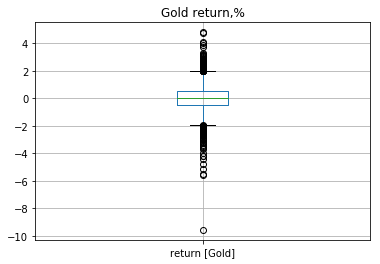

In [177]:
df.boxplot(grid=True) 
plt.title('Gold return,%')
plt.show()

Long-term return tends to zero - market is efficient in long-term. 
In short term outliers provide inefficiencies. Probability distribution function:

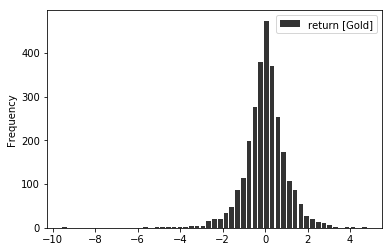

In [178]:
df.plot.hist(bins=int(np.sqrt(len(df))),rwidth=0.8,alpha=0.8,color='black')
plt.show()

In [179]:
df.describe()

,return [Gold]
count,2815.000000
mean,0.020649
std,0.978162
min,-9.569265
25%,-0.469342
50%,0.038976
75%,0.514210
max,4.809496


Test for normal distribution (ND) of PDF:

In [180]:
z,p=stats.normaltest(df['return [Gold]'])
print('Probability that PDF differs from Normal Distribution:',100*round(p,2),'%')

Probability that PDF differs from Normal Distribution: 0.0 %


Create visual representation. Ranges (1 sigma) of are added:

In [181]:
description=df.describe()

mean=float(description.iloc[1])
std=float(description.iloc[2])

u=round(mean+std,2)
l=round(mean-std,2)

Create figure.Recent point is marked by 'bold':

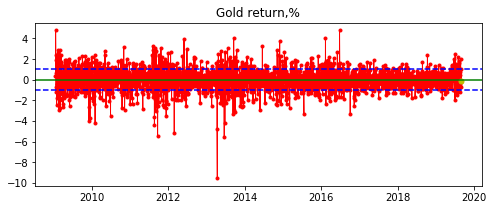

In [182]:
plt.figure(figsize=(8,3))

plt.plot(df['return [Gold]'],color='r',marker='o',linewidth=1, markersize=3)
plt.plot(df.index[-1], df.values[-1],'oy',markersize=5)

plt.axhline(y=mean,color='g',linestyle='-')
plt.axhline(y=u,color='b',linestyle='--')
plt.axhline(y=l,color='b',linestyle='--')

plt.title('Gold return,%')
plt.show()

Create animation file:

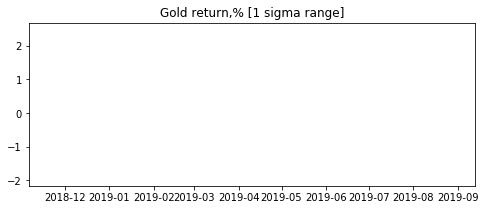

In [183]:
fig=plt.figure(figsize=(8,3))
plt.title('Gold return,% [1 sigma range]')
camera=Camera(fig)

for i in range((len(df)-200),len(df)):
    
    ms='or' if (df.values[i]>u or df.values[i]<l) else 'oy'
    plt.plot(df.index[i],df.values[i],ms,markersize=8)
    
    plt.axhline(y=mean,color='g',linestyle='-')
    plt.axhline(y=u,color='b',linestyle='--')
    plt.axhline(y=l,color='b',linestyle='--')
    
    camera.snap()

animation=camera.animate()
animation.save('series.gif', writer=LoopingPillowWriter(fps=7))  

Check return for stationarity by ADF test: 

In [184]:
z=df['return [Gold]'].values
result=adfuller(z)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -53.338338
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


We can reject the null hypothesis - strongly negative ADF statistic. Look at the ACF for volatility: 

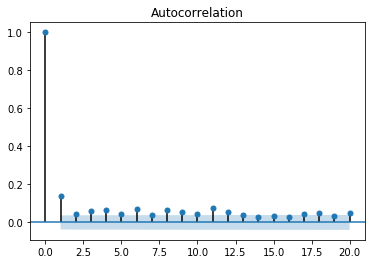

In [185]:
df['Volatility']=df['return [Gold]']**2
sm.graphics.tsa.plot_acf(df['Volatility'].values, lags=20)
plt.show()
del df['Volatility']

Clustering of volatility is not observed - requirements for Markovian model are satisfied. 
We may define the difference of returns in frame of Ornstein–Uhlenbeck process:

In [186]:
df['Difference']=df['return [Gold]'].diff() 
df['return [Gold]']=df['return [Gold]'].shift(1,axis = 0)
df.dropna(inplace=True)

Rescale by average of return (3):

In [187]:
return_mean=df['return [Gold]'].mean()
df['return [Gold]']=df['return [Gold]']-return_mean
df.dropna(inplace=True)

Boxplot for both parameters:

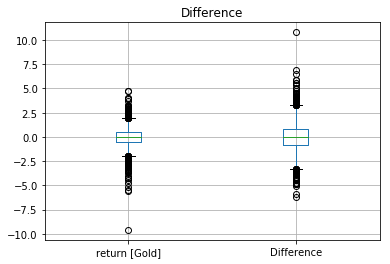

In [188]:
df.boxplot(grid=True) 
plt.title('Difference')
plt.show()

Mapping of return-difference hides uncertainty - hidden parameters are probably lost. 
Person correlation and significance of H0 hypothesis:

In [189]:
pc=sc.stats.pearsonr(list(df['return [Gold]']),list(df['Difference']))

print('Difference vice return correlation (Pearson):',int(100*round(pc[0],2)),'%')
print('Difference vice return 2-tailed p-value:',round(pc[1],2))
print('Difference vice return R2:',round(pc[0]**2,2))

Difference vice return correlation (Pearson): -71 %
Difference vice return 2-tailed p-value: 0.0
Difference vice return R2: 0.5


Scatter plot:

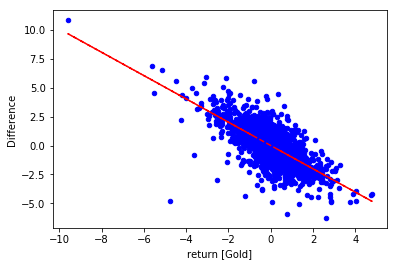

Slope: -1.01


In [190]:
df.plot.scatter(x='return [Gold]',y='Difference',color='blue') 

x=list(df['return [Gold]'])
y=list(df['Difference'])

z=np.polyfit(x,y,1)
p=np.poly1d(z)

plt.plot(x,p(x),"r--")
plt.show()

print('Slope:',round(p[1],2))

Calcultation of mean reversion decay time - return decreases by 4 times. It is the recommended time of position hold:

In [191]:
reverse_time=int(round(-math.log(4)/p[1]))
print('Mean reversion time:',reverse_time,'day')

Mean reversion time: 1 day


Definition of expected return for decay time after inverse rescaling:

In [192]:
exp_return=0.25*df['return [Gold]'].values[-1]+return_mean
print('Expected return:',round(exp_return,2),'%')

Expected return: -0.17 %


Now we can consider nonlinear algos. We do make binning of return range in the following way:

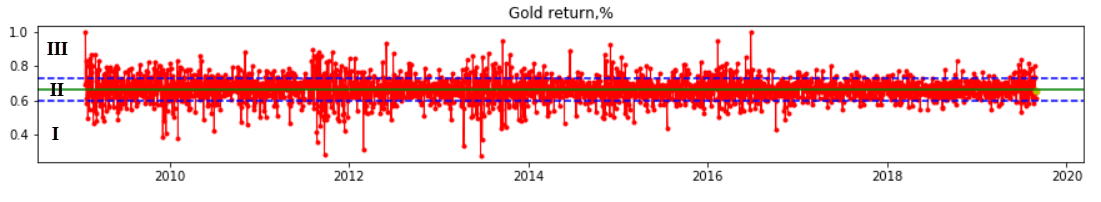

In [193]:
Image(filename='images/gold_return.png',width=700,height=120)